# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [2]:
variables = ['psl']
variable = 'psl'
TITLE = 'Sea Level Pressure'
ylabel = '$E_{psl}$ ($Pa$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/home/globc/peatier/CNRMppe_save/PPE/ENSEMBLE2/files/npy/'

### List of members

In [13]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [14]:
def get_3D_psl_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    psl = df['psl']
    
    return psl

# Get data 

### Reference simulation p1

In [15]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_psl_xarr(path, filename, variables)

In [16]:
amip={}
amip['p1'] = p1_amip

### PPE simulations 

In [17]:
# PPE amip simulations 
filename='*_amip_*.nc'
N=len(nb_p_list)

i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_psl_xarr(path, filename, variables)
    i=i+1

In [18]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [19]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

### GMMIP simulations

In [20]:
path_GMMIP = '/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/GMMIP/CNRM/'
filename = variable+'_Amon*.nc'

In [21]:
file = xr.open_mfdataset(path_GMMIP+filename,concat_dim='member')
X_GMMIP_tmp = file[variables].mean('time', keep_attrs=True) 
X_GMMIP = X_GMMIP_tmp[variable].rename({'member' : 'time'})
X_GMMIP

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.DataArray 'psl' (time: 8, lat: 128, lon: 256)>
dask.array<mean_agg-aggregate, shape=(8, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time
Attributes:
    standard_name:       air_pressure_at_mean_sea_level
    long_name:           Sea Level Pressure
    units:               Pa
    CDI_grid_type:       gaussian
    CDI_grid_num_LPE:    64
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    description:         not, in general, the same as surface pressure
    history:             none
    cell_measures:       area: areacella

### NCEP observations

In [22]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [23]:
path_observation =  '/data/scratch/globc/peatier/obs_data/NCEP/regrid_CNRM/'
filename_obs = 'psl_1m_1979-1981_NCEP_regrid.nc'

In [24]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename_obs,combine='by_coords')
#file
variables = ['psl']
df_obs = load_monthly_clim(path_observation, filename_obs, variables)
df_obs

psl
month lat        lon                     
1     -88.927735 0.00000     99413.804688
                 1.40625     99413.843750
                 2.81250     99413.851562
                 4.21875     99413.757812
                 5.62500     99413.578125
...                                   ...
12     88.927735 352.96875  101209.882812
                 354.37500  101209.617188
                 355.78125  101209.382812
                 357.18750  101209.171875
                 358.59375  101208.929688

[393216 rows x 1 columns]

In [25]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    psl      (lat, lon) float32 102419.08 102429.44 ... 101503.29 101503.664

### Remove mean and multiply by spatial weights

In [26]:
## --Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [27]:
## --PPE simulations
mean = matrix.mean(axis=0)
anom = matrix - mean
anom_w = (anom*W_eof_3D)

In [28]:
## --Reference simulation p1
p1_amip_anom = p1_amip - mean
p1_amip_w = p1_amip_anom*W_eof_2D

In [29]:
## --GMMIP simulations
X_GMMIP = X_GMMIP - mean
X_GMMIP_w = X_GMMIP*W_eof_3D

In [30]:
## --Observations
X_obs = obs[variable] - mean
X_obs_w = X_obs*W_eof_2D

# Calcule full MSE (ej)

In [31]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

def RMSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

In [32]:
# Reference p1
mod = amip['p1']
observation = obs[variable]

diff_p1 = MSE(mod, observation, W_rmse_2D)
print(float(diff_p1))

34436.37022414589


In [33]:
test = RMSE(mod, observation, W_rmse_2D)
print(float(test))

185.57039156111594


In [34]:
print(float(sqrt(diff_p1)))

185.57039156111594


In [35]:
observation = obs[variable]
ej_list = []

for p in nb_p_list :
    mod = amip[p]
    ej_tmp = MSE(mod, observation, W_rmse_2D)
    ej_list.append(ej_tmp)

### Save

In [36]:
np.save(path_files+'npy/CNRMppe_decomposition_ej_'+str(variable)+'.npy', ej_list)

# EOF 

In [37]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

In [38]:
eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(npcs=100, pcscaling=1)

In [39]:
varFrac = solver.varianceFraction(neigs=100)
#varFrac

### Save

In [40]:
for i in range(0,len(eof),1) : 
    j = i+1
    # EOFmap
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    EOF_df.to_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy")

In [41]:
## --Save the pc_p1 and pc_PPE in a .nc files
path_file = path_files+'nc/'
filename = 'CNRMppe_decomposition_p1_EOFpc_'+str(variable)+'.nc'
pc[0, :].to_netcdf(path=path_file+filename)
filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
pc[1:, :].to_netcdf(path=path_file+filename)

In [42]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df.to_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy')

In [43]:
np.save(path_files+'npy/W_eof_2D_'+str(variable)+'.npy', W_eof_2D)
np.save(path_files+'npy/W_eof_3D_'+str(variable)+'.npy', W_eof_3D)
np.save(path_files+'npy/W_rmse_2D_'+str(variable)+'.npy', W_rmse_2D)

# Compute error

### Functions

In [44]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [45]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [46]:
## --Get the pc_PPE
path_file = path_files+'nc/'
filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
pc_PPE = xr.open_dataset(path_file+filename)
EOF_nb=3
pc_PPE_trunc = pc_PPE['pcs'][:,(EOF_nb-1)]
pc_PPE_trunc

<xarray.DataArray 'pcs' (time: 102)>
array([ 1.589222,  0.078354, -0.058577, -0.25224 , -1.120532, -0.33341 ,
        0.338332,  0.34674 ,  3.365255,  0.122476, -1.027237,  0.505675,
        0.562433, -0.092279, -0.87685 ,  0.185789,  1.018273,  0.242151,
       -0.266942, -0.714202,  0.830593,  0.02498 ,  1.100903,  1.800029,
       -0.491482, -1.545701, -0.642233, -1.474645, -0.896321,  0.703184,
       -0.960359,  0.016547, -1.172374,  0.287125,  0.510861,  1.033503,
       -0.563152,  0.91104 , -0.763829, -1.480656,  1.74005 , -0.88208 ,
       -0.67372 , -0.057017,  0.202754,  0.233998, -0.762667,  0.864174,
        0.289375,  1.04694 , -0.460808,  0.102838, -0.445469,  0.043804,
        1.691519, -1.073998, -0.294685,  0.405672,  0.085742, -1.143309,
       -0.520478, -0.863495, -0.459462,  2.199138, -0.901331,  0.803435,
        0.189323, -1.000768, -0.73639 , -0.602188,  0.300313, -1.747277,
        0.338184,  0.127598, -0.132393,  0.864902,  1.794763,  1.338658,
        0.804558, -0.518325, -0.845518, -0.317399,  1.156674,  1.2496  ,
        0.37784 ,  0.436771,  0.489057, -0.071935, -1.481132,  0.102301,
        0.680151,  0.313789, -1.109209,  2.605698,  0.814688, -2.4722  ,
        1.082099, -1.981318, -1.387434, -0.578636, -0.756191, -0.857927])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 ... 94 95 96 97 98 99 100 101 102
    mode     int64 2

### Emulation and optimization

In [47]:
def MultiLinReg_pred(x, EOF_nb, variable) :
    
    ## --Get the pc_PPE
    path_file = path_files+'nc/'
    filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
    pc_PPE = xr.open_dataset(path_file+filename)
    pc_PPE['pcs'][:,(EOF_nb-1)]

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = pc_PPE['pcs'][:,(EOF_nb-1)]
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy", allow_pickle=True)
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save(path_file_npy+'/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save(path_file_npy+'/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [48]:
## --Full function predict PC from x + reconstruct 3D field + compute partial RMSE

def function_MSE_emulator_std(x, variable, eofs_combined, X_rec_obs, Mean, 
                               W_eof_2D, W_rmse_2D, nb_modes): 
    pc=[]
    for i in range(1,(nb_modes+1),1) :
        tmp = MultiLinReg_pred(x, i, variable)
        pc.append(tmp)
    
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims=2)
    
    E = MSE_rec(X_rec_mod, X_rec_obs, Mean, W_rmse_2D)
    
    return E

def function_MSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, 
                           W_rmse_2D, nb_modes): 
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_MSE_emulator_std(x_std, variable, eofs_combined, 
                                   X_rec_obs, Mean, W_eof_2D, W_rmse_2D, nb_modes)
    return float(E)

In [49]:
# -- FONCTION JACOBIAN RMSE

def jacobian_RMSE(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D, nb_modes) :
    
    ## -- Data
      
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    nb_dims = 2 
    
    ## -- A = RMSE_rec
    A = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, 
                               W_rmse_2D, nb_modes)
    #print(A)
    ## -- B = Sigma(2*(X_mod - X_rec_obs))
    toto = x - MEAN
    x_std = toto/STD
    
    pc=[]
    for i in range(1,(nb_modes+1),1) :
        tmp = MultiLinReg_pred(x, i, variable)
        pc.append(tmp)
        
    X_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    
    add = X_mod - X_rec_obs
    tmp = 2*eofs_combined*add
    B = tmp.sum(['lat', 'lon'])
    
    ## C = Beta*eofs_combined
    pc_beta = []
    for i in range(1,(nb_modes+1),1) :
        tmp = np.load(path_file_npy+'/Beta'+str(i)+'.npy')
        pc_beta.append(tmp)
    C = xr.DataArray(pc_beta, dims = ['eofs', 'param']).transpose()
    
    ## -- jac = 1/(2*A) * B * C
    tmp1 = 1/(2*float(A)) 
    tmp2 = np.dot(C, B)
    jac = np.dot(tmp1, tmp2)
    
    return jac

In [50]:
# -- FONCTION JACOBIAN MSE

def jacobian_MSE(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D, nb_modes) :
    
    ## -- Data
      
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    nb_dims = 2 
    
    ## -- A = RMSE_rec
    #A = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, 
    #                           W_rmse_2D, nb_modes)
    #print(A)
    ## -- B = Sigma(2*(X_mod - X_rec_obs))
    toto = x - MEAN
    x_std = toto/STD
    
    pc=[]
    for i in range(1,(nb_modes+1),1) :
        tmp = MultiLinReg_pred(x, i, variable)
        pc.append(tmp)
        
    X_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    
    add = X_mod - X_rec_obs
    tmp = 2*eofs_combined*add
    B = tmp.sum(['lat', 'lon'])
    
    ## C = Beta*eofs_combined
    pc_beta = []
    for i in range(1,(nb_modes+1),1) :
        tmp = np.load(path_file_npy+'/Beta'+str(i)+'.npy')
        pc_beta.append(tmp)
    C = xr.DataArray(pc_beta, dims = ['eofs', 'param']).transpose()
    
    ## -- jac = 1/(2*A) * B * C
    #tmp1 = 1/(2*float(A)) 
    tmp2 = np.dot(C, B)
    #jac = np.dot(tmp1, tmp2)
    jac=tmp2
    
    return jac

In [51]:
## --Functions optimization

def Optimization(x_best, ind, xlim, variable, eofs_combined, X_rec_obs, 
                 Mean, W_eof_2D, W_rmse_2D, nb_modes) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    cpt=0
    
    fun_x0 = function_MSE_emulator(x0, variable, eofs_combined, X_rec_obs, 
                                        Mean, W_eof_2D, W_rmse_2D, nb_modes)
    print('fun_x0 = '+str(fun_x0))
  
    sol = minimize(function_MSE_emulator,  x0, 
                    args=(variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, 
                          W_rmse_2D, nb_modes), 
                    method='SLSQP', jac = jacobian_MSE,
                    bounds=xlim, 
                    options={'disp': True, 'ftol' : 0.001, 'maxiter' : 100})    
    
    fun_x = function_MSE_emulator(sol.x, variable, eofs_combined, X_rec_obs, 
                                         Mean, W_eof_2D, W_rmse_2D, nb_modes)
    
    return fun_x

### Initial guess for Optimization 1

In [52]:
path_file_csv = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv"
param = pd.read_csv(path_file_csv+"/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]
#param_names

In [53]:
# READ FROM ROMAIN REF NAMELIST 
p1_params = {}
p1_params['AKN'] = 0.16997374320907874
p1_params['ALPHAT'] = 1.7500958814177299
p1_params['ALD'] = 1.750291056519555
p1_params['ALMAVE'] = 15.00068477221974
p1_params['AGREF'] = -0.036
p1_params['AGRE1'] = 5.5
p1_params['AGRE2'] = 0.0
p1_params['RAUTEFR'] = 0.001
p1_params['RQLCR'] = 0.0005249804129062814
p1_params['RAUTEFS'] = 0.0052
p1_params['RQICRMIN'] = 0.0000001
p1_params['RQICRMAX'] = 0.000021
p1_params['TFVL'] = 0.02
p1_params['TFVI'] = 0.04
p1_params['TFVR'] = 3.0
p1_params['TFVS'] = 0.6
p1_params['RKDN'] = 0.00005
p1_params['RKDX'] = 0.0001
p1_params['TENTR'] = 0.000004
p1_params['TENTRX'] = 0.000057
p1_params['VVN'] = -2.0
p1_params['VVX'] = -35.0
p1_params['ALFX'] = 0.04
p1_params['FNEBC'] = 10.0
p1_params['GCTURB'] = 0.00005
p1_params['RLWINHF_ICE'] = 0.9
p1_params['RLWINHF_LIQ'] = 0.9
p1_params['RSWINHF_ICE'] = 0.71
p1_params['RSWINHF_LIQ'] = 0.71
p1_params['REFLCAPE'] = 2.0

p1_params_list = []
for i in param_names : 
    tmp = p1_params[i]
    p1_params_list.append(tmp)

## Save data p1 params
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_params.npy', p1_params_list)

In [54]:
x0 = p1_params_list
#x0

In [55]:
param = pd.read_csv(path_file_csv+"/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

# Loop over 1 to 100 modes considered

In [56]:
path_file = path_files+'npy/'
filename = 'CNRMppe_decomposition_mean_'+str(variable)+'.npy'
Mean =  pd.read_pickle(path_file+filename).to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

### Evolution of errors depending on EOF modes number

In [57]:
## --Get the pc_PPE
path_file = path_files+'nc/'
filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
pc_PPE = xr.open_dataset(path_file+filename)

## --Get the pc_pred 
#path_file = path_files+'nc/'
#filename = 'CNRMppe_decomposition_EOFpc_pred_test_'+str(variable)+'.nc'
#pc_pred = xr.open_dataset(path_file+filename)

df_PPE = pd.DataFrame(ej_list, columns=['e'])
#df_pred = pd.DataFrame(ej_list[80:], columns=['e'])
df_GMMIP = pd.DataFrame()

In [58]:
p_mean_PPE = []
p_std_PPE = []

p_mean_GMMIP = []
p_std_GMMIP = []

p_p1 = []

u_mean = []
u_std = []

eta = []

delta_mean =[]
delta_std = []

for i in range(2,101,1) :
    print(i)
    ## --Get the data
    eofs=[]
    for j in range(1,i+1,1) :
        ## --Get the eofs
        eof_tmp = pd.read_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy").to_xarray().to_array()
        eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
        eofs.append(eof_tmp)
        
    ## --Combine the modes for reconstruction
    eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
    
    ## --Get and reconstruct the pc_PPE
    pc_PPE_trunc = pc_PPE['pcs'][:,0:i]
    X_PPE_rec = reconstruct_X(eofs_combined, pc=pc_PPE_trunc.transpose(), nb_dims=3)
    
    ## --Project and reconstruct the observations
    U_obs = solver.projectField(X_obs_w, neofs=i, weighted=False, eofscaling=1)
    X_obs_rec = reconstruct_X(eofs_combined, pc=U_obs, nb_dims=2)
    
    ## --Project and reconstruct the GMMIP data
    U_GMMIP = solver.projectField(X_GMMIP_w, neofs=i, weighted=False, eofscaling=1)
    X_GMMIP_rec = reconstruct_X(eofs_combined, pc=U_GMMIP.transpose(), nb_dims=3)
    
    ## --Project and reconstruct p1
    U_p1 = solver.projectField(p1_amip_w, neofs=i, weighted=False, eofscaling=1)
    X_p1_rec = reconstruct_X(eofs_combined, pc=U_p1, nb_dims=2)
    
    ## --Compute reconstructed RMSE r
    p_PPE = MSE_rec(X_PPE_rec, X_obs_rec, Mean, W_rmse_2D)
    p_GMMIP = MSE_rec(X_GMMIP_rec, X_obs_rec, Mean, W_rmse_2D)
    p_p1_tmp = MSE_rec(X_p1_rec, X_obs_rec, Mean, W_rmse_2D)
      
    ## -- Optimization 
    #sol_fun = Optimization(x0, 0.001, xlim, variable, eofs_combined, X_obs_rec, 
    #                  Mean, W_eof_2D, W_rmse_2D, nb_modes=i)
     
    ## --Build DataFrame and compute means and standard deviations 
    
    ### -- Parametric
    df_PPE['p_'+str(i)] = p_PPE
    p_mean_PPE_tmp = df_PPE['p_'+str(i)].mean()
    p_std_PPE_tmp = df_PPE['p_'+str(i)].std()
    p_mean_PPE.append(p_mean_PPE_tmp)
    p_std_PPE.append(p_std_PPE_tmp)
    ## --p1
    p_p1.append(p_p1_tmp)
    ## --eta
    #df_PPE['eta_'+str(i)] = sol_fun
    #eta_tmp = df_PPE['eta_'+str(i)].mean()
    #eta.append(eta_tmp)
    
    df_GMMIP['p_'+str(i)] = p_GMMIP
    p_mean_GMMIP_tmp = df_GMMIP['p_'+str(i)].mean()
    p_std_GMMIP_tmp = df_GMMIP['p_'+str(i)].std()
    p_mean_GMMIP.append(p_mean_GMMIP_tmp)
    p_std_GMMIP.append(p_std_GMMIP_tmp)
    
    ### -- Non-parametric
    df_PPE['u_'+str(i)] = df_PPE['e'] - df_PPE['p_'+str(i)]
    u_mean_tmp = df_PPE['u_'+str(i)].mean()
    u_std_tmp = df_PPE['u_'+str(i)].std()
    u_mean.append(u_mean_tmp)
    u_std.append(u_std_tmp)
    ## --delta
    #df_PPE['delta_'+str(i)] =  df_PPE['p_'+str(i)] - df_PPE['eta_'+str(i)]
    #delta_mean_tmp = df_PPE['delta_'+str(i)].mean()
    #delta_std_tmp = df_PPE['delta_'+str(i)].std()
    #delta_mean.append(delta_mean_tmp)
    #delta_std.append(delta_std_tmp)
    
    

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


### Build DataFrame for Figure

In [59]:
p_p1_list = []
for i in p_p1 : 
    tmp = float(i)
    p_p1_list.append(tmp)
#p_p1_list

In [60]:
## --Mean and std of full RMSE 
ej_mean = df_PPE['e'].mean()
ej_std = df_PPE['e'].std()

## --Build DataFrame for figure
df_fig = pd.DataFrame(p_mean_PPE, columns=['p_mean_PPE'])
df_fig['p_std_PPE'] = p_std_PPE
df_fig['u_mean_PPE'] = u_mean
df_fig['u_std_PPE'] = u_std
#df_fig['eta_mean_PPE'] = eta
#df_fig['e_optim'] = df_fig['eta_mean_PPE'] + df_fig['u_mean_PPE']
#df_fig['delta_mean_PPE'] = delta_mean
#df_fig['delta_std_PPE'] = delta_std

df_fig['p_p1'] = p_p1_list

df_fig['p_mean_GMMIP'] = p_mean_GMMIP
df_fig['p_std_GMMIP'] = p_std_GMMIP


df_fig['modes'] = range(2,101,1)
df_fig

,p_mean_PPE,p_std_PPE,u_mean_PPE,u_std_PPE,p_p1,p_mean_GMMIP,p_std_GMMIP,modes
0,39765.940845,38763.602679,31255.936904,4237.496376,6017.434615,5479.071271,3340.935772,2
1,41181.720770,38841.824493,29840.156978,3804.684736,6063.650358,5823.521760,3116.217597,3
2,42993.221805,39558.881798,28028.655943,2836.193641,6192.093285,6616.119561,2792.347682,4
3,44363.944074,39438.873438,26657.933675,2164.364048,6547.641506,6887.568432,2704.796331,5
4,45239.071403,39316.702249,25782.806346,1913.831346,7967.134055,7816.295715,2615.677774,6
...,...,...,...,...,...,...,...,...
94,61683.651035,39225.681947,9338.226714,29.794796,25074.854985,24817.166122,2238.069266,96
95,61740.855777,39224.865803,9281.021972,24.834849,25157.135774,24869.996320,2239.343557,97
96,61777.946705,39224.631442,9243.931044,21.243955,25189.945351,24915.350802,2242.093944,98
97,61782.335140,39224.878434,9239.542609,20.821207,25194.444306,24921.172554,2240.155821,99


In [61]:
## --Ratio of full error in PPE 
ratio_ej_mean = (ej_mean/ej_mean)*100
ratio_ej_std = (ej_std/ej_mean)*100

df_fig['ratio_ej_mean'] = [ratio_ej_mean]*99
df_fig['ratio_ej_std'] = [ratio_ej_std]*99

df_fig['ej_mean'] = [ej_mean]*99
df_fig['ej_std'] = [ej_std]*99

df_fig['ratio_p_mean'] = (df_fig['p_mean_PPE']/ej_mean)*100
df_fig['ratio_p_std'] = (df_fig['p_std_PPE']/ej_mean)*100

df_fig['ratio_p_mean_GMMIP'] = (df_fig['p_mean_GMMIP']/ej_mean)*100
df_fig['ratio_p_std_GMMIP'] = (df_fig['p_std_GMMIP']/ej_mean)*100

df_fig['ratio_u_mean'] = (df_fig['u_mean_PPE']/ej_mean)*100
df_fig['ratio_u_std'] = (df_fig['u_std_PPE']/ej_mean)*100

#df_fig['ratio_eta'] = (df_fig['eta_mean_PPE']/ej_mean)*100
#df_fig['ratio_e_optim'] = (df_fig['e_optim']/ej_mean)*100

#df_fig['ratio_delta_mean'] = (df_fig['delta_mean_PPE']/ej_mean)*100
#df_fig['ratio_delta_std'] = (df_fig['delta_std_PPE']/ej_mean)*100

df_fig['ratio_p_p1'] = (df_fig['p_p1']/ej_mean)*100
df_fig

,p_mean_PPE,p_std_PPE,u_mean_PPE,u_std_PPE,p_p1,p_mean_GMMIP,p_std_GMMIP,modes,ratio_ej_mean,ratio_ej_std,ej_mean,ej_std,ratio_p_mean,ratio_p_std,ratio_p_mean_GMMIP,ratio_p_std_GMMIP,ratio_u_mean,ratio_u_std,ratio_p_p1
0,39765.940845,38763.602679,31255.936904,4237.496376,6017.434615,5479.071271,3340.935772,2,100.0,55.229374,71021.877749,39224.938696,55.991114,54.579805,7.714625,4.704094,44.008886,5.966466,8.472649
1,41181.720770,38841.824493,29840.156978,3804.684736,6063.650358,5823.521760,3116.217597,3,100.0,55.229374,71021.877749,39224.938696,57.984556,54.689943,8.199617,4.387687,42.015444,5.357060,8.537722
2,42993.221805,39558.881798,28028.655943,2836.193641,6192.093285,6616.119561,2792.347682,4,100.0,55.229374,71021.877749,39224.938696,60.535180,55.699572,9.315608,3.931673,39.464820,3.993408,8.718572
3,44363.944074,39438.873438,26657.933675,2164.364048,6547.641506,6887.568432,2704.796331,5,100.0,55.229374,71021.877749,39224.938696,62.465180,55.530598,9.697812,3.808399,37.534820,3.047461,9.219190
4,45239.071403,39316.702249,25782.806346,1913.831346,7967.134055,7816.295715,2615.677774,6,100.0,55.229374,71021.877749,39224.938696,63.697374,55.358579,11.005476,3.682918,36.302626,2.694707,11.217859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,61683.651035,39225.681947,9338.226714,29.794796,25074.854985,24817.166122,2238.069266,96,100.0,55.229374,71021.877749,39224.938696,86.851620,55.230421,34.942988,3.151239,13.148380,0.041952,35.305818
95,61740.855777,39224.865803,9281.021972,24.834849,25157.135774,24869.996320,2239.343557,97,100.0,55.229374,71021.877749,39224.938696,86.932165,55.229272,35.017374,3.153033,13.067835,0.034968,35.421671
96,61777.946705,39224.631442,9243.931044,21.243955,25189.945351,24915.350802,2242.093944,98,100.0,55.229374,71021.877749,39224.938696,86.984389,55.228942,35.081234,3.156906,13.015611,0.029912,35.467867
97,61782.335140,39224.878434,9239.542609,20.821207,25194.444306,24921.172554,2240.155821,99,100.0,55.229374,71021.877749,39224.938696,86.990568,55.229289,35.089431,3.154177,13.009432,0.029317,35.474202


# Figure

In [4]:
df_fig = load(path_files+'npy/Error_decomposition_df_'+variable+'.npy', allow_pickle=True)
df_fig['ratio_p_mean'][8]

66.55494239272366

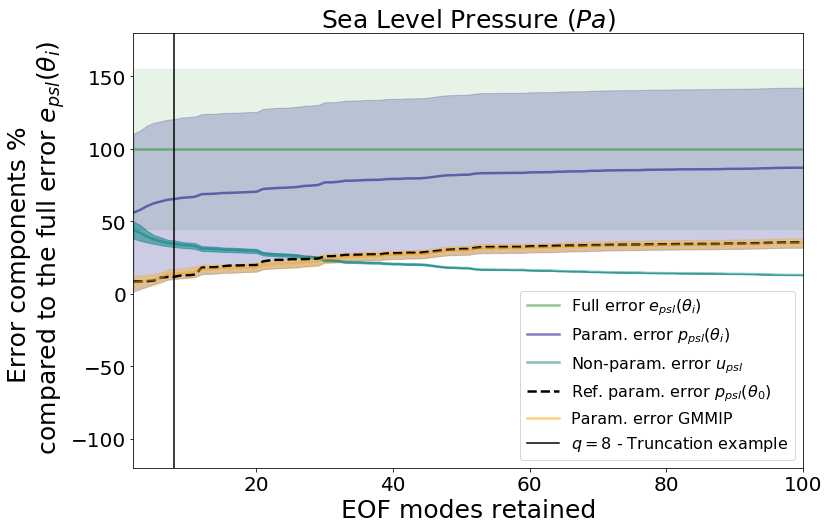

In [65]:
plt.figure(figsize=(12, 8))
ax = plt.gca()

## --------- PPE simulations, full error e :
df_fig.plot(kind='line', x='modes', y='ratio_ej_mean', color = 'forestgreen', 
            alpha=0.5, linewidth=2.5, ax=ax)
xfit = df_fig['modes']
yfit = df_fig['ratio_ej_mean']
dyfit = df_fig['ratio_ej_std']#/2
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='forestgreen', alpha=0.1)

## --------- PPE simulations, param. p :
df_fig.plot(kind='line', x='modes', y='ratio_p_mean', color = 'navy', 
            alpha=0.5, linewidth=2.5, ax=ax)
xfit = df_fig['modes']
yfit = df_fig['ratio_p_mean']
dyfit = df_fig['ratio_p_std']#/2
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='navy', alpha=0.2)
## --------- PPE simulations, non-param. u :
df_fig.plot(kind='line', x='modes', y='ratio_u_mean', color = 'teal', 
            alpha=0.5, linewidth=2.5, ax=ax)
xfit = df_fig['modes']
yfit = df_fig['ratio_u_mean']
dyfit = df_fig['ratio_u_std']#/2
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='teal', alpha=0.5)
## --------- PPE simulations, p1 :
df_fig.plot(kind='line', x='modes', y='ratio_p_p1', linestyle = 'dashed', 
            color = 'black', alpha=1, linewidth=2.5, ax=ax)
## --------- Optim, eta :
#df_fig.plot(kind='line', x='modes', y='ratio_eta', linestyle = 'dashed', 
#            color = 'red', alpha=0.7, linewidth=2.5, ax=ax)
## --------- Optim, e :
#df_fig.plot(kind='line', x='modes', y='ratio_e_optim', linestyle = 'solid', 
#            color = 'black', alpha=1, linewidth=2.5, ax=ax)
## --------- Optim, delta :
#df_fig.plot(kind='line', x='modes', y='ratio_delta_mean', color = 'brown', 
#            alpha=0.7, linewidth=3, ax=ax)
#xfit = df_fig['modes']
#yfit = df_fig['ratio_delta_mean']
#dyfit = df_fig['ratio_delta_std']#/2
#plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='brown', alpha=0.1)

## --------- GMMIP dataset :
df_fig.plot(kind='line', x='modes', y='ratio_p_mean_GMMIP', color = 'orange', 
            alpha=0.5, linewidth=2.5, ax=ax)
xfit = df_fig['modes']
yfit = df_fig['ratio_p_mean_GMMIP']
dyfit = df_fig['ratio_p_std_GMMIP']#/2
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='orange', alpha=0.3)

## ----- Truncation
ax.axvline(8, color='black')

## ----- Graphisme / Legend
ax.set_ylim(-120, 180)
ax.set_xlabel('EOF modes retained', size = 25)
ax.set_ylabel('Error components % \n compared to the full error $e_{psl}(\\theta_i)$', size = 25)
ax.set_title('Sea Level Pressure ($Pa$)', fontsize=25)
#ax.set_xscale('log')
ax.tick_params(axis='y', which='both', labelsize=20)
ax.tick_params(axis='x', which='both', labelsize=20)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)



# Legend .................

legend = [ 'Full error $e_{psl}(\\theta_i)$',
          'Param. error $p_{psl}(\\theta _i)$',
          'Non-param. error $u_{psl}$', 
          'Ref. param. error $p_{psl}(\\theta_0)$', 
          #'Optim. param. error $p_{pr}(\\hat{\\theta})$',
          #'Delta [PPE - optim] $p_{\delta}(\\theta_i)$',
          'Param. error GMMIP',
          '$q=8$ - Truncation example']
ax.get_legend().remove()
ax.legend(legend, fontsize=16, loc='lower right')
#bbox_to_anchor=(1.05, 1)    , bbox_to_anchor=(1.65, 0.83)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Decompo_error_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [66]:
## -- SAVE : 
df_fig.to_pickle(path_files+'npy/Error_decomposition_df_'+variable+'.npy')

# Tests on the sum of the components

In [6]:
df_fig = np.load(path_files+'npy/Error_decomposition_df.npy', allow_pickle=True)
df_fig

,p_mean_PPE,p_std_PPE,u_mean_PPE,u_std_PPE,eta_mean_PPE,e_optim,delta_mean_PPE,delta_std_PPE,p_p1,p_mean_GMMIP,...,ratio_p_std_GMMIP,ratio_u_mean,ratio_u_std,ratio_eta,ratio_e_optim,ratio_delta_mean,ratio_delta_std,ratio_p_p1,ej_mean,ej_std
0,0.737982,0.775185,1.854433,0.250425,0.391054,2.245487,0.346927,0.775185,0.414253,0.368330,...,1.892347,71.533039,9.659903,15.084561,86.617600,13.382400,29.902064,15.979417,2.592414,0.805136
1,0.914878,0.785260,1.677536,0.192878,0.401808,2.079344,0.513070,0.785260,0.442127,0.406123,...,1.437395,64.709411,7.440087,15.499388,80.208800,19.791200,30.290696,17.054627,2.592414,0.805136
2,0.938077,0.790744,1.654338,0.185293,0.416869,2.071206,0.521208,0.790744,0.442817,0.410125,...,1.419276,63.814555,7.147500,16.080327,79.894883,20.105117,30.502231,17.081245,2.592414,0.805136
3,1.228846,0.817055,1.363568,0.102512,0.540980,1.904548,0.687866,0.817055,0.698785,0.649172,...,1.601059,52.598386,3.954290,20.867826,73.466212,26.533788,31.517137,26.954978,2.592414,0.805136
4,1.326109,0.812759,1.266305,0.083141,0.580232,1.846537,0.745877,0.812759,0.835055,0.772328,...,2.081424,48.846543,3.207105,22.381916,71.228459,28.771541,31.351433,32.211481,2.592414,0.805136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1.928924,0.805114,0.663490,0.001231,1.088099,1.751589,0.840825,0.805114,1.350003,1.289875,...,1.847354,25.593511,0.047491,41.972418,67.565930,32.434070,31.056525,52.075125,2.592414,0.805136
95,1.929716,0.805114,0.662698,0.001058,1.088784,1.751482,0.840932,0.805114,1.351125,1.291246,...,1.839488,25.562969,0.040794,41.998857,67.561826,32.438174,31.056524,52.118396,2.592414,0.805136
96,1.930111,0.805149,0.662303,0.000938,1.087598,1.749902,0.842512,0.805149,1.351288,1.291355,...,1.841645,25.547746,0.036192,41.953113,67.500860,32.499140,31.057895,52.124678,2.592414,0.805136
97,1.931230,0.805159,0.661184,0.000636,1.089686,1.750871,0.841543,0.805159,1.352162,1.293027,...,1.849695,25.504582,0.024542,42.033651,67.538233,32.461767,31.058254,52.158415,2.592414,0.805136


In [36]:
df_fig.iloc[-1]

p_mean_PPE              1.931341
p_std_PPE               0.805144
u_mean_PPE              0.661073
u_std_PPE               0.000612
eta_mean_PPE            1.088323
e_optim                 1.749396
delta_mean_PPE          0.843018
delta_std_PPE           0.805144
p_p1                    1.352239
p_mean_GMMIP            1.293189
p_std_GMMIP             0.048034
modes                 100.000000
ratio_ej_mean         100.000000
ratio_ej_std           31.057399
ratio_p_mean           74.499696
ratio_p_std            31.057705
ratio_p_mean_GMMIP     49.883581
ratio_p_std_GMMIP       1.852881
ratio_u_mean           25.500304
ratio_u_std             0.023600
ratio_eta              41.981048
ratio_e_optim          67.481351
ratio_delta_mean       32.518649
ratio_delta_std        31.057705
ratio_p_p1             52.161376
ej_mean                 2.592414
ej_std                  0.805136
Name: 98, dtype: float64